# Protibolitics

In [28]:
# Translation boolean relations among gene reation rule (This class if from Genobolitics)
class FoldChange:
    def __init__(self, fold_change):
        self.fold_change = fold_change

    # OR IS MAX, MAX IS PLUS, THUS OR IS PLUS
    def __add__(self, other):
        return FoldChange(FoldChange.max_with_missing_values(self.fold_change, other.fold_change))

    # AND IS MIN, MIN IS MINUS, THUS AND IS MINUS
    def __sub__(self, other):
        return FoldChange(FoldChange.min_with_missing_values(self.fold_change, other.fold_change))

    @staticmethod
    def max_with_missing_values(*args):
        return max(FoldChange.replace_missing(*args, replace_with=-math.inf))

    @staticmethod
    def min_with_missing_values(*args):
        return min(FoldChange.replace_missing(*args, replace_with=math.inf))

    @staticmethod
    def replace_missing(*args, replace_with):
        replaced = [replace_with if o is None else o for o in args]
        if not all(args):
            warnings.warn('some operands are missing from logical expression!')
        return replaced

In [29]:
class Protibolitics(MetaboliticsAnalysis):
    def __init__(self, *args, **kwargs):
        super(Protibolitics, self).__init__(*args, **kwargs)  # inheriting from MetaboliticsAnalysis
        self.model.solver = kwargs.get('solver', 'glpk')   # Set glpk as the linear solver
        
    def set_objective(self, Protein_measures):           # The new objective based on protein measures
        
        self.clean_objective()                           # Clean the current objective
        
        for rx in self.model.reactions:
            fold_change = self.sample_reaction_fold_change(rx, Protein_measures)
            # Objective is 0 if fold change is inf or empty string
            if fold_change in {math.inf, -math.inf, None}:
                rx.objective_coefficient = 0.0
                warnings.warn('objective-coeff is set to ZERO!')
            else:
                rx.objective_coefficient = fold_change

    
    def sample_reaction_fold_change(self, rx, Protein_measures):
        map_list = [('or', '+'),('and', '-')] 
        # list to use with replace function
        for gene in rx.genes:
            map_list.append((gene.id, 'FoldChange({})'.format(Protein_measures.get(gene.id, 'None'))))
            
        boolean_relation = reduce(lambda x, y: x.replace(*y), map_list, rx.gene_reaction_rule)

        fold_change = None
        if boolean_relation:
            fold_change = eval(boolean_relation).fold_change
        else:
            # empty
            warnings.warn('reaction rule is empty!')
 

        return fold_change
        
        
        
def flux_variance_analysis(X, y):
    Protibolitics_transformer = MetaboliticsTransformer()
    Protibolitics_transformer.analyzer = Protibolitics("recon2")
    Protibolitics_transformer.n_jobs = 1

    pipeline = Pipeline([('scaling', FoldChangeScaler(reference_label='healthy')),
                         ('LP_FVA', Protibolitics_transformer)])

    return pipeline.fit_transform(X, y)

In [ ]:
y = labels[0:40]
x = Protein_measures[0:40]
rx_boundaries = flux_variance_analysis(x, y)

### Saving reaction boundaries since it's computationally expensive 

In [ ]:
def save_file(data, file_name):
    file = open(file_name, 'wb')
    pickle.dump(data, file)
    file.close()

save_file(rx_boundaries, 'rx_boundaries_file')
save_file(y, 'labels')

In [30]:
# loading computed boundaries and labels
def open_file(file_name):
    file = open(file_name, 'rb')
    data = pickle.load(file)
    file.close()
    return data

rx_boundaries = open_file("rx_boundaries_file")
y = open_file("labels")

# Pathway level diff scores

reaction-diff: converts min-max values to diff score by computing the avg.

pathway-scoring: converts reaction diff scores into pathway diff scores (#100 pathway)

transport-elimination: eliminates transport pathway in final dataset.

In [31]:
diff_pipe= MetaboliticsPipeline(['reaction-diff', 'pathway-transformer','transport-pathway-elimination'])
pathway_scores = diff_pipe.fit_transform(rx_boundaries, y)
len(pathway_scores[0])

91

# Statistical Signifcance Analysis and most significant Pathways

 feature-selection:feature selection select significant reactions.

In [39]:
diff_fs_pipe = MetaboliticsPipeline(['reaction-diff', 'feature-selection', 'pathway-transformer', 'transport-pathway-elimination'])

pathways_scores_fs = diff_fs_pipe.fit_transform(rx_boundaries, y)

# ANOVA
df_selected_pathways = feature_importance_report(pathways_scores_fs, y)
df_selected_pathways

labels,healthy,unhealthy,F,pval
ROS detoxification,9.473903e-15,485.079023,6.244130,0.070968
"Valine, leucine, and isoleucine metabolism",-9.473903e-15,677.942334,6.237066,0.070968
Starch and sucrose metabolism,-2.368476e-15,-28.580760,6.490742,0.070968
Miscellaneous,5.684342e-14,-729.163122,7.921524,0.070968
Glycolysis/gluconeogenesis,-4.736952e-15,1013.738437,5.557322,0.070968
Folate metabolism,-2.368476e-14,648.806282,5.909265,0.070968
Pyruvate metabolism,1.136868e-13,-488.259467,5.622156,0.070968
"Glycine, serine, alanine and threonine metabolism",5.684342e-14,-684.004885,4.927469,0.078436
Citric acid cycle,-3.789561e-14,-130.119126,4.859909,0.078436
Pyrimidine synthesis,1.326346e-13,-836.301530,4.608427,0.078623


# Heatmap

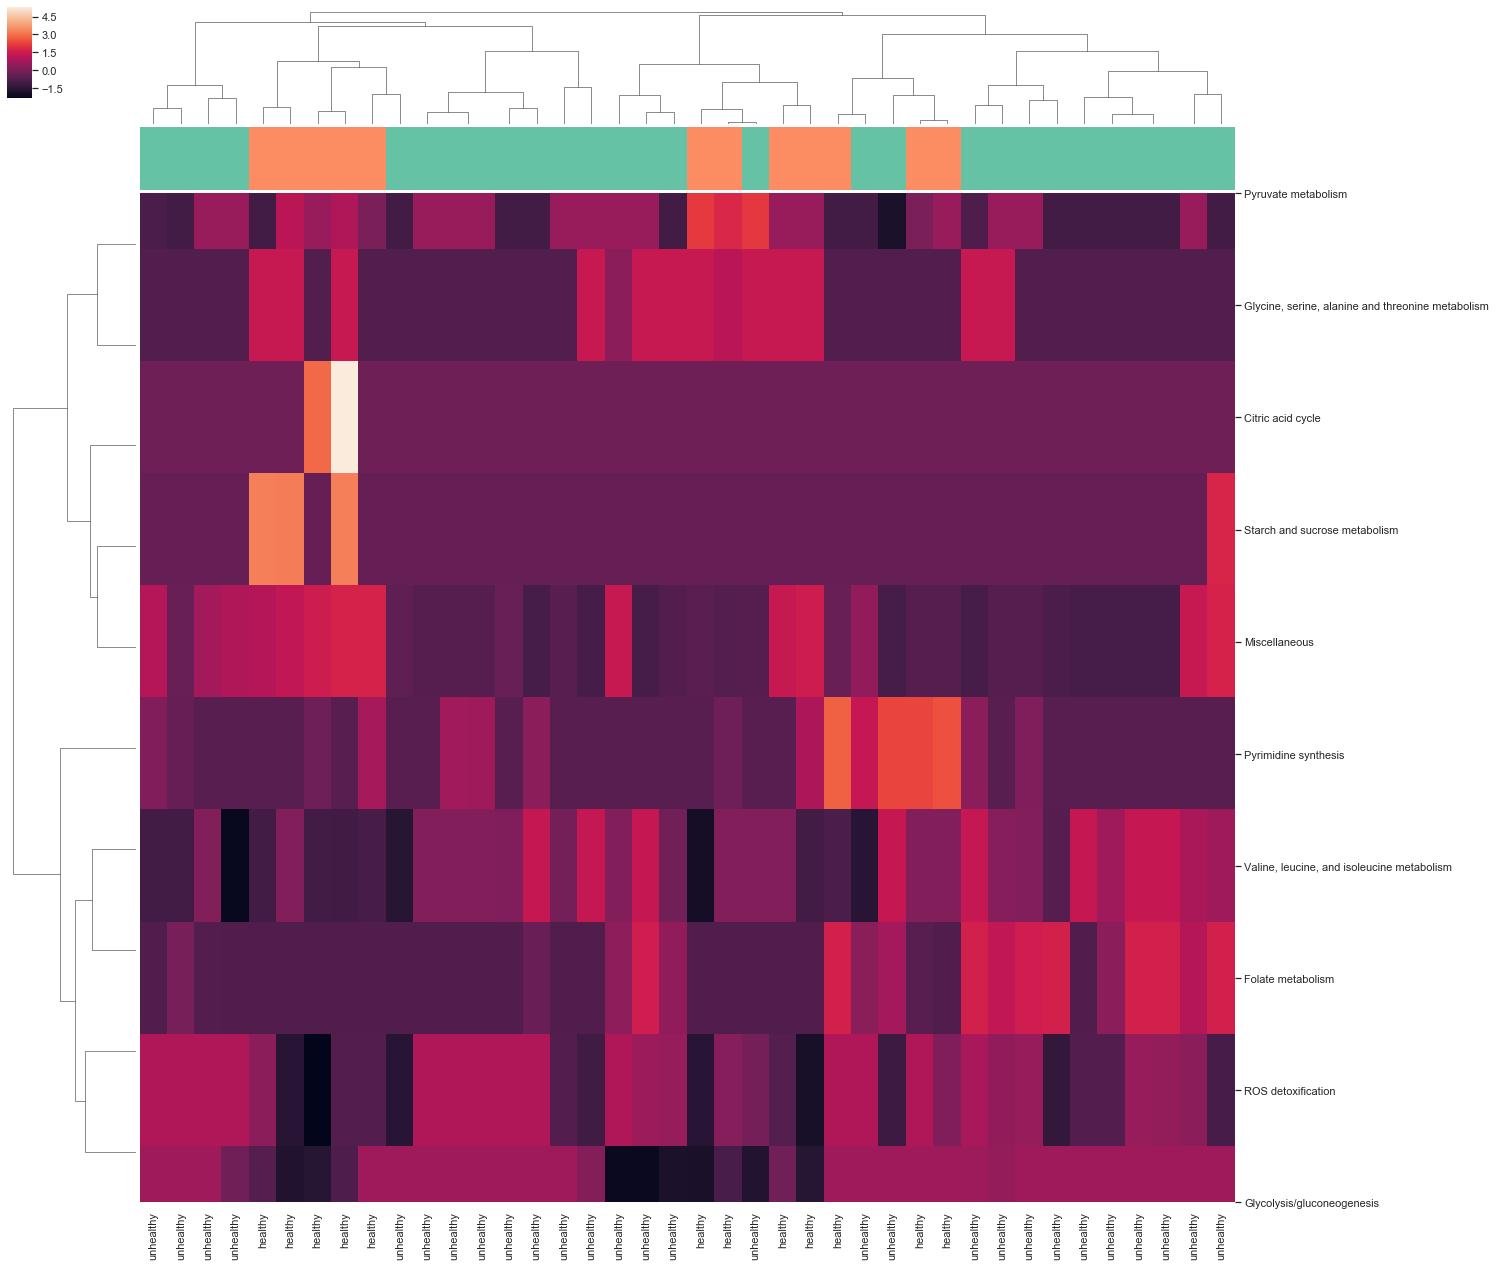

In [33]:
plot_heatmap(pathways_scores_fs, y)

# Machine-Learning-based Classification

In [35]:
s_cv = StratifiedKFold(n_splits=10, random_state=43)

### Logistic Logistic Regression

In [37]:
pipe = Pipeline([
            ('dy', diff_pipe),
            ('vect', DictVectorizer(sparse=False)),
            ('clf', LogisticRegression(C=0.3e-6, random_state=43))
        ])

scores = cross_val_score(pipe, rx_boundaries, y, cv=s_cv, n_jobs=1, scoring='accuracy')
print('kfold test: {}'.format(scores))
print('mean: {}'.format(scores.mean().round(5)))
print('std: {}'.format(scores.std().round(5)))

C:\Users\taylankabbani2019\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432 FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Users\taylankabbani2019\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432 FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Users\taylankabbani2019\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432 FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Users\taylankabbani2019\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432 FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
C:\Users\taylankabbani2019\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logi

kfold test: [0.6        0.6        0.75       0.75       0.75       0.75
 0.75       0.75       0.66666667 0.66666667]
mean: 0.70333
std: 0.06092
